# Exploratory Data Analysis - Financial News Dataset

This notebook performs exploratory data analysis on the Financial News and Stock Price Integration Dataset (FNSPID).

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set plot style
plt.style.use("ggplot")
sns.set(style="whitegrid")

# Download NLTK resources
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to C:\Users\DELL/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Loading

In [6]:
# Load the analyst ratings data
analyst_df = pd.read_csv("../data/raw/raw_analyst_ratings.csv")

# Display the first few rows
analyst_df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


## Basic Data Exploration

In [3]:
# Check data shape
print(f"Dataset shape: {analyst_df.shape}")

# Check column names
print("\nColumn names:")
print(analyst_df.columns.tolist())

# Check data types
print("\nData types:")
print(analyst_df.dtypes)

# Check for missing values
print("\nMissing values:")
print(analyst_df.isnull().sum())

Dataset shape: (1407328, 6)

Column names:
['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']

Data types:
Unnamed: 0     int64
headline      object
url           object
publisher     object
date          object
stock         object
dtype: object

Missing values:
Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64


## Descriptive Statistics

### 1. Basic Statistics for Textual Lengths

Headline Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


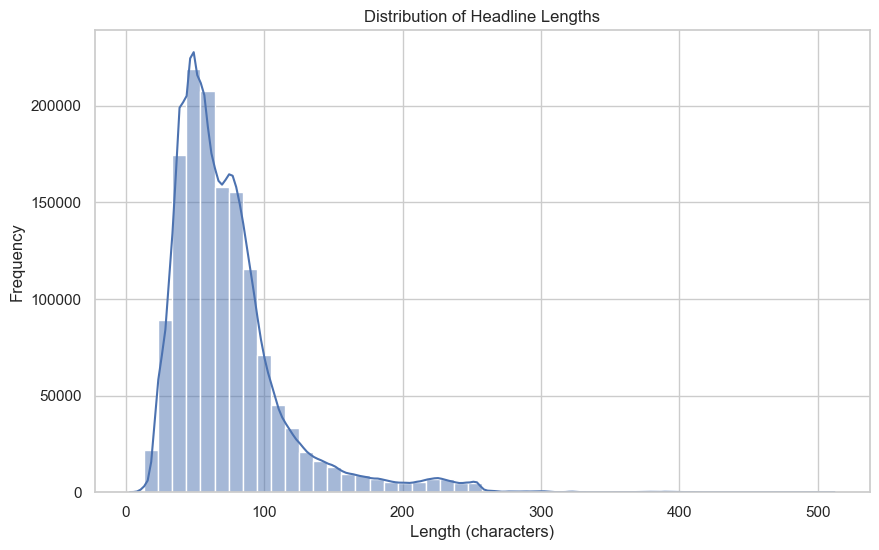

In [4]:
# Calculate headline length
analyst_df["headline_length"] = analyst_df["headline"].astype(str).apply(len)

# Basic statistics for headline length
print("Headline Length Statistics:")
print(analyst_df["headline_length"].describe())

# Visualize headline length distribution
plt.figure(figsize=(10, 6))
sns.histplot(analyst_df["headline_length"], bins=50, kde=True)
plt.title("Distribution of Headline Lengths")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### 2. Articles per Publisher Analysis

Top 10 Most Active Publishers:
           publisher  article_count
0      Paul Quintaro         228373
1         Lisa Levin         186979
2  Benzinga Newsdesk         150484
3      Charles Gross          96732
4      Monica Gerson          82380
5       Eddie Staley          57254
6         Hal Lindon          49047
7      ETF Professor          28489
8         Juan Lopez          28438
9     Benzinga Staff          28114


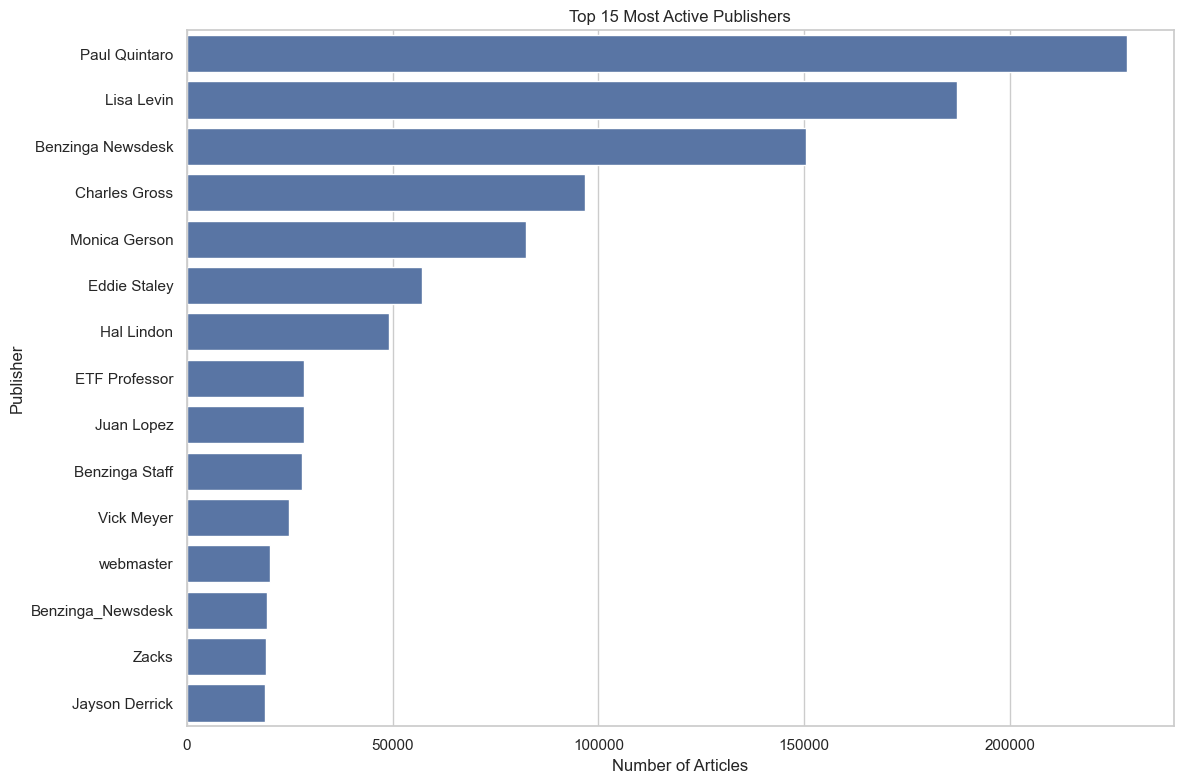

In [5]:
# Count articles per publisher
publisher_counts = analyst_df["publisher"].value_counts().reset_index()
publisher_counts.columns = ["publisher", "article_count"]

print("Top 10 Most Active Publishers:")
print(publisher_counts.head(10))

# Visualize top publishers
plt.figure(figsize=(12, 8))
sns.barplot(x="article_count", y="publisher", data=publisher_counts.head(15))
plt.title("Top 15 Most Active Publishers")
plt.xlabel("Number of Articles")
plt.ylabel("Publisher")
plt.tight_layout()
plt.show()

### 3. Publication Date Trends Analysis

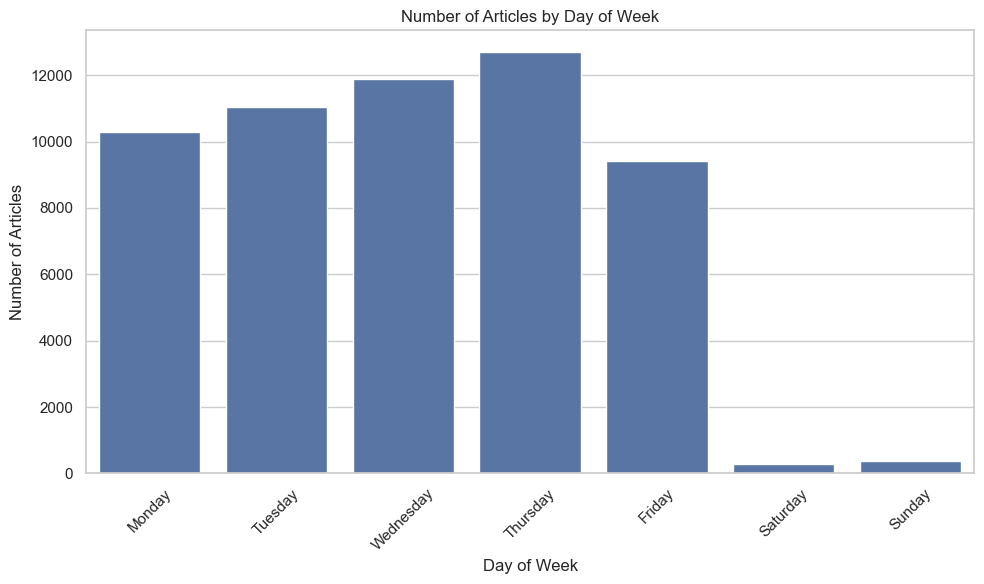

C:\Users\DELL\AppData\Local\Temp\ipykernel_34576\3832779110.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  analyst_df["year_month"] = analyst_df["date"].dt.to_period("M")


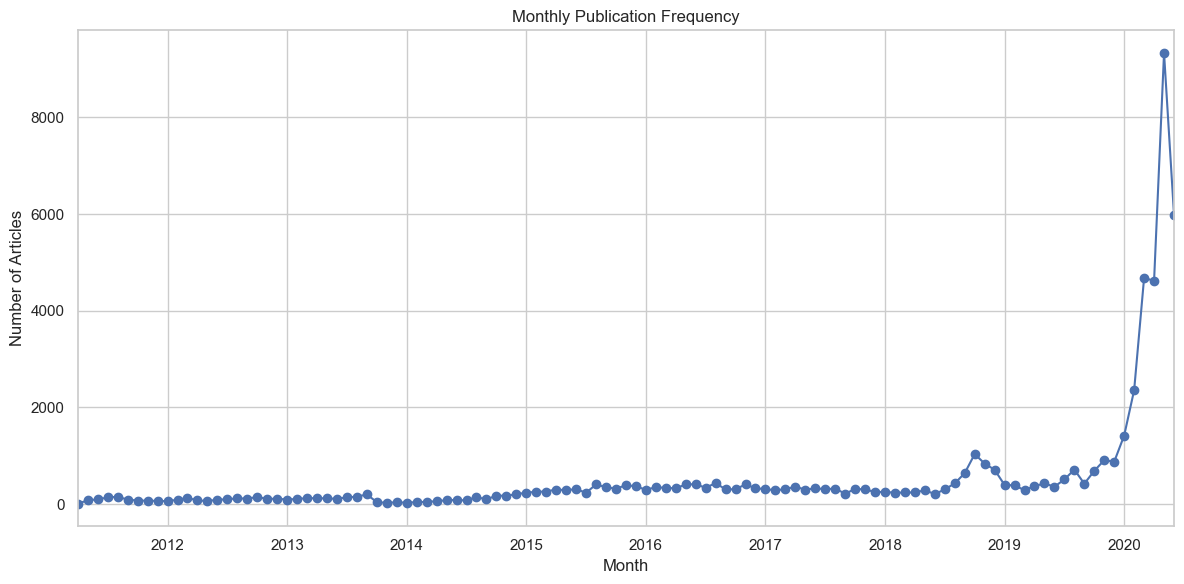

In [7]:
# converting 
analyst_df["date"] = pd.to_datetime(analyst_df["date"], errors='coerce', utc=True)

# Extract day of week
analyst_df["day_of_week"] = analyst_df["date"].dt.day_name()

# Analyze articles by day of week
day_counts = analyst_df["day_of_week"].value_counts()

# Reorder days for better visualization
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_counts = day_counts.reindex(days_order)

plt.figure(figsize=(10, 6))
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title("Number of Articles by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly trends
analyst_df["year_month"] = analyst_df["date"].dt.to_period("M")
monthly_counts = analyst_df.groupby("year_month").size()

plt.figure(figsize=(12, 6))
monthly_counts.plot(kind="line", marker="o")
plt.title("Monthly Publication Frequency")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.tight_layout()
plt.show()

## Text Analysis (Topic Modeling)

[nltk_data] Downloading package punkt to C:\Users\DELL/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


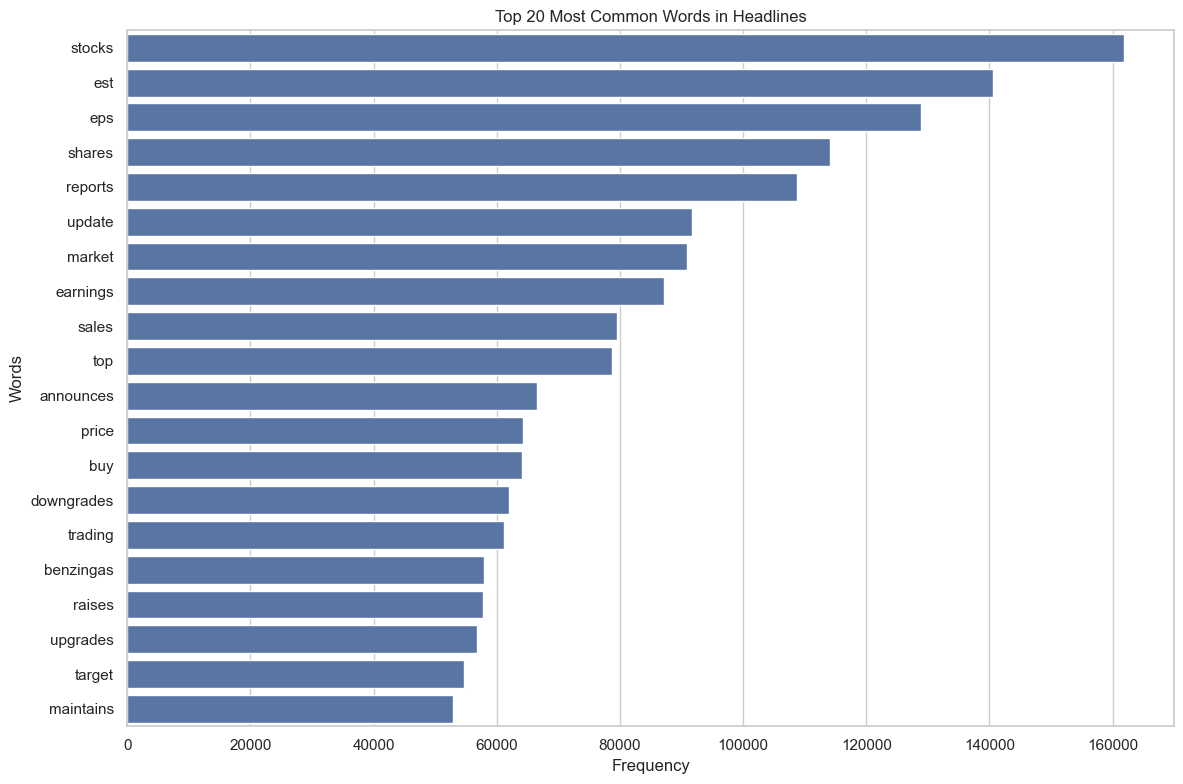


Number of headlines containing "fda": 11382
Sample headlines:
['Agilent Technologies Receives FDA Approval for PD-L1 as a Companion Diagnostic', 'Agilent Reports FDA Approval For PD-L1 Companion Diagnostic On Dako Omni', "Agilent Shares Unaffected As Hearing FDA Approved Co.'s PD-L1 IHC 22C3 PharmDx Assay For Expanded Use"]

Number of headlines containing "approval": 5880
Sample headlines:
['Agilent Technologies Receives FDA Approval for PD-L1 as a Companion Diagnostic', 'Agilent Reports FDA Approval For PD-L1 Companion Diagnostic On Dako Omni', 'Agilent Companion Diagnostic Receives Expanded FDA Approval For PD-L1 IHC 22C3 PharmDx']

Number of headlines containing "price": 76056
Sample headlines:
['B of A Securities Maintains Neutral on Agilent Technologies, Raises Price Target to $88', 'CFRA Maintains Hold on Agilent Technologies, Lowers Price Target to $85', 'UBS Maintains Neutral on Agilent Technologies, Raises Price Target to $87']

Number of headlines containing "target": 56858


In [7]:
# Download required NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
# Define text preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return []
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Process headlines
analyst_df["processed_headline"] = analyst_df["headline"].astype(str).apply(preprocess_text)

# Extract all words
all_words = []
for words in analyst_df["processed_headline"]:
    all_words.extend(words)

# Count word frequencies
word_freq = Counter(all_words)

# Get the most common words
common_words = word_freq.most_common(20)

# Plot word frequencies
plt.figure(figsize=(12, 8))
words, counts = zip(*common_words)
sns.barplot(x=list(counts), y=list(words))
plt.title("Top 20 Most Common Words in Headlines")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.tight_layout()
plt.show()

# Find headlines with specific key terms
key_terms = ["fda", "approval", "price", "target", "upgrade", "downgrade"]

for term in key_terms:
    term_headlines = analyst_df[analyst_df["headline"].str.lower().str.contains(term, na=False)]
    print(f"\nNumber of headlines containing \"{term}\": {len(term_headlines)}")
    if len(term_headlines) > 0:
        print("Sample headlines:")
        print(term_headlines["headline"].head(3).tolist())

## Time Series Analysis

### 1. Publication Frequency Over Time

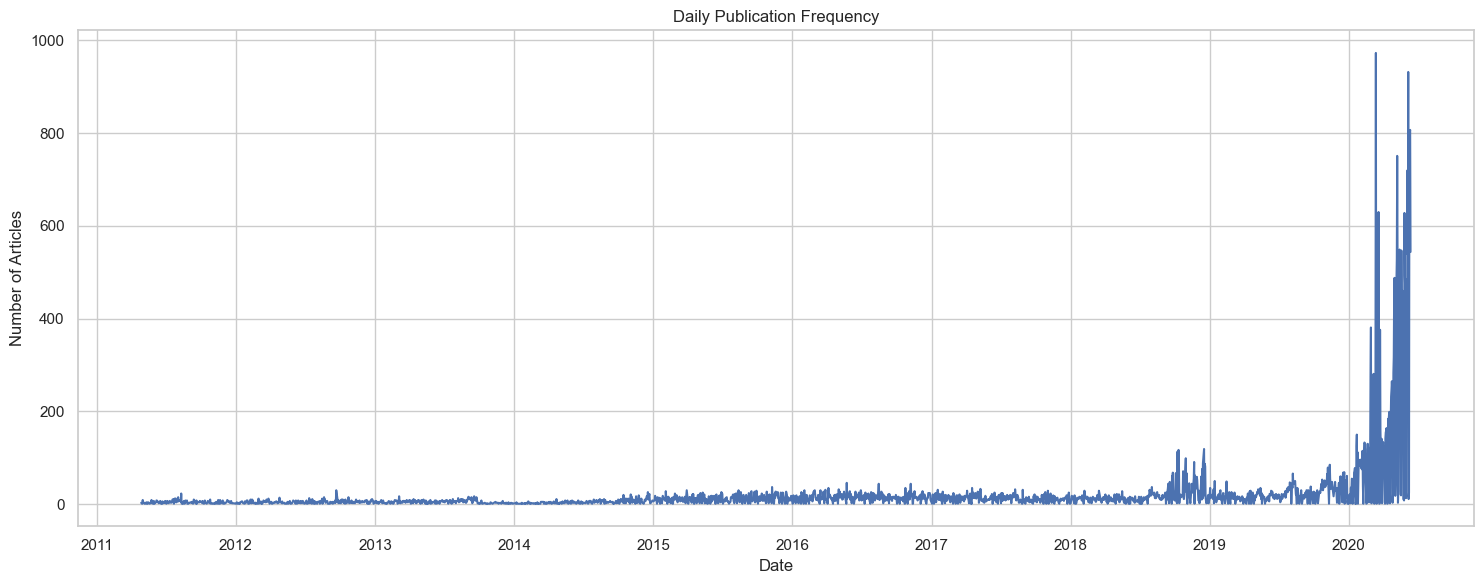

Average daily articles: 22.38
Threshold for spike detection: 159.32

Days with article spikes:

date
2020-02-27    275
2020-02-28    381
2020-03-06    281
2020-03-11    282
2020-03-12    973
2020-03-19    630
2020-03-23    376
2020-03-24    160
2020-04-09    164
2020-04-13    184
2020-04-15    186
2020-04-16    199
2020-04-17    194
2020-04-20    181
2020-04-21    232
2020-04-22    246
2020-04-23    265
2020-04-24    246
2020-04-27    283
2020-04-28    317
2020-04-29    449
2020-04-30    488
2020-05-01    385
2020-05-04    347
2020-05-05    478
2020-05-06    529
2020-05-07    751
2020-05-08    508
2020-05-11    485
2020-05-12    388
2020-05-13    549
2020-05-14    536
2020-05-15    322
2020-05-18    547
2020-05-19    332
2020-05-20    461
2020-05-21    333
2020-05-22    286
2020-05-26    628
2020-05-27    492
2020-05-28    465
2020-05-29    309
2020-06-01    484
2020-06-02    361
2020-06-03    720
2020-06-04    538
2020-06-05    932
2020-06-08    765
2020-06-09    803
2020-06-10    807

In [8]:
# Daily article count
daily_counts = analyst_df.groupby(analyst_df["date"].dt.date).size()

# Plot daily frequency
plt.figure(figsize=(15, 6))
daily_counts.plot()
plt.title("Daily Publication Frequency")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.tight_layout()
plt.show()

# Detect spikes in article publications
threshold = daily_counts.mean() + 2 * daily_counts.std()
spike_days = daily_counts[daily_counts > threshold]

print(f"Average daily articles: {daily_counts.mean():.2f}")
print(f"Threshold for spike detection: {threshold:.2f}")
print(f"\nDays with article spikes:\n")
print(spike_days)

### 2. Analysis of Publishing Times

In [9]:
# Check if time information is available
if "time" in analyst_df.columns:
    # Convert time to datetime
    analyst_df["full_datetime"] = pd.to_datetime(analyst_df["date"].astype(str) + " " + analyst_df["time"].astype(str))
    
    # Extract hour
    analyst_df["hour"] = analyst_df["full_datetime"].dt.hour
    
    # Count articles by hour
    hour_counts = analyst_df["hour"].value_counts().sort_index()
    
    # Plot articles by hour
    plt.figure(figsize=(12, 6))
    sns.barplot(x=hour_counts.index, y=hour_counts.values)
    plt.title("Number of Articles by Hour of Day")
    plt.xlabel("Hour of Day (24-hour format)")
    plt.ylabel("Number of Articles")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    print("Peak publishing hours:\n")
    peak_hours = hour_counts.nlargest(3)
    for hour, count in peak_hours.items():
        print(f"Hour {hour}: {count} articles")
else:
    print("Time information not available in the dataset.\nOnly date information is available.")

Time information not available in the dataset.
Only date information is available.


## Publisher Analysis

### 1. Publishers Contribution Analysis

In [10]:
# Top publishers (already analyzed above in descriptive statistics)
# Analyze the type of news different publishers report

# Get top publishers
top_publishers = publisher_counts.head(5)["publisher"].tolist()

# Analyze which stocks each publisher covers most
for publisher in top_publishers:
    publisher_data = analyst_df[analyst_df["publisher"] == publisher]
    stock_counts = publisher_data["stock"].value_counts().head(5)
    
    print(f"\n{publisher} - Top 5 Covered Stocks:\n")
    for stock, count in stock_counts.items():
        print(f"{stock}: {count} articles")

NameError: name 'publisher_counts' is not defined

### 2. Email Domain Analysis (if applicable)


Top 10 Email Domains in Publisher Names:

domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_34576\2824263731.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_publishers["domain"] = email_publishers["publisher"].apply(lambda x: x.split("@")[1] if "@" in x else "")


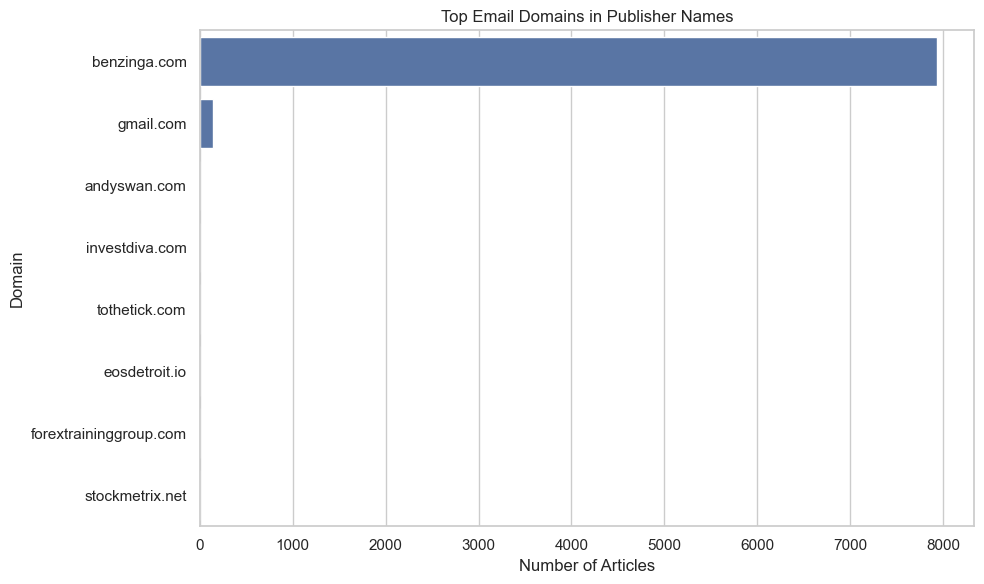

In [11]:
# Check if any publisher names contain @ symbol (email addresses)
email_publishers = analyst_df[analyst_df["publisher"].str.contains("@", na=False)]

if len(email_publishers) > 0:
    # Extract domains from email addresses
    email_publishers["domain"] = email_publishers["publisher"].apply(lambda x: x.split("@")[1] if "@" in x else "")
    
    # Count domains
    domain_counts = email_publishers["domain"].value_counts().head(10)
    
    print("\nTop 10 Email Domains in Publisher Names:\n")
    print(domain_counts)
    
    # Visualize domains
    plt.figure(figsize=(10, 6))
    sns.barplot(x=domain_counts.values, y=domain_counts.index)
    plt.title("Top Email Domains in Publisher Names")
    plt.xlabel("Number of Articles")
    plt.ylabel("Domain")
    plt.tight_layout()
    plt.show()
else:
    print("\nNo email addresses found in publisher names.")

## Summary of Findings

Based on the exploratory data analysis, here are the key findings:

1. **Headline Statistics**:
   - The analysis provided basic statistics for headline lengths
   - We can see the distribution pattern and identify any outliers

2. **Publisher Analysis**:
   - We identified the most active publishers contributing to the news feed
   - We analyzed which stocks different publishers tend to cover most
   - If applicable, we examined email domains used as publisher names

3. **Time Trends**:
   - We analyzed publication frequency by day of week and month
   - We identified days with unusually high publication activity (spikes)
   - If available, we analyzed the distribution of publishing times throughout the day

4. **Text Analysis**:
   - We extracted and visualized the most common words in headlines
   - We identified headlines containing key terms like "FDA approval" and "price target"

These findings provide valuable insights into the structure and patterns of the financial news data, which will inform our sentiment analysis and correlation studies in subsequent notebooks.